In [1]:
using Distributed

In [2]:
workers()

1-element Vector{Int64}:
 1

In [3]:
addprocs(2)
;

In [4]:
nworkers()

2

In [5]:
@everywhere using FastaIO
@everywhere using MultivariateStats
@everywhere using LinearAlgebra
@everywhere using DelimitedFiles
@everywhere using StatsBase
@everywhere using DCAUtils
@everywhere using Plots
@everywhere using Random
@everywhere using Printf
@everywhere using LinearAlgebra
@everywhere using GLM
@everywhere using Statistics
@everywhere using KitMSA

In [6]:
@everywhere include("../src/Basic_code/read_write.jl")
@everywhere include("../src/Basic_code/energy.jl")
@everywhere include("../src/Basic_code/msa_tools.jl")
@everywhere include("../src/Basic_code/extra_tools.jl")


In [7]:


function amino_seq2dna_seq(seq)
    seq_dna=[]
    for a in seq
        push!(seq_dna, sample(amino2cod[a]))
    end
    return seq_dna
end

function dna_seq2amino_seq(seq_dna)
    new = []
    for a in seq_dna
        push!(new, cod2amino[a])
    end
    return new
end

function pairwise_hamming(msa::Array{Int8,2})
    num_seqs = size(msa, 1)
    pairwise_distances = Array{Int,1}(undef, num_seqs*(num_seqs-1)÷2)
    idx = 1
    for i in 1:num_seqs-1
        for j in i+1:num_seqs
            dist = KitMSA.my_hamming(msa[i,:], msa[j,:])
            pairwise_distances[idx] = dist
            idx += 1
        end
    end
    return pairwise_distances
end


function eliminate(msa, tresh, idx)
    L = length(msa[idx,:])
    trimmed_msa = []
    for i in 1:length(msa[:,1])
        d = KitMSA.my_hamming(msa[idx,:], msa[i,:])
        if  d > L*tresh
            push!(trimmed_msa, msa[i,:])
        end
    end
    push!(trimmed_msa, msa[idx,:])
    return hcat(trimmed_msa...)'
end


function reweighting(msa, tresh)
    final_msa =[]
    new_msa = deepcopy(msa)
    a = 0
    for i in 1:20000
        new_msa = eliminate(new_msa, tresh, 1)
    end    
    println(length(new_msa[:,1]))
    return new_msa
end

function project_pca(filename, label1, label2, eigenv, pc_ref, one_non_ref)
    pc_proj = eigenv[:, [end, end-1]]'*one_non_ref'
    scatter(pc_nat[1,:], pc_nat[2,:], alpha = 0.25, label= label1, legend=:topright)
    scatter!(pc_proj[1,:], pc_proj[2,:], alpha = 0.25,color=:red, label= label2 )
    savefig(filename)
end

function plot_pca(pc_ref, eigenv, matrices, filepath)
    
    for i in 1:length(matrices)
        one_hot_proj = one_hot(matrices[i])
        project_pca(joinpath(filepath, "pca$(i).png"), "nat", "sil step $(i)", eigenv, pc_ref, one_hot_proj)
        println(i)
    end
end

plot_pca (generic function with 1 method)

In [8]:
@everywhere function Delta_energy(h::Array{Float64,2}, J::Array{Float64,4}, 
        S::Array{<:Integer,1}, ref::Array{<:Integer, 1})
    q, N = size(h)
    E = 0.0
    
    index_v = collect(1:N)
    common = (S .== ref)
    idx = findfirst(isequal(false), common)
    common = index_v[common]
    #println(idx)
    #println(common)
    E -= (h[S[idx],idx] - h[ref[idx],idx])
    @fastmath for j = 1:N
        if j > idx
            @inbounds  E -= (J[S[j],S[idx],j,idx] - J[ref[j],ref[idx],j,idx] )
        end
    end
    
    @fastmath for i in common
        if idx > i
            @inbounds  E -= (J[S[idx],S[i],idx,i] - J[ref[idx],ref[i],idx,i] )
        end
    end
    
    return E
end


In [9]:
@everywhere function get_accessible_nucleo_muts_metro_DNA_det_bal(old_cod)
    if old_cod .== "---"
        amino_list = [i for i in 1:21]
        codon_list = reduce(vcat,[amino2cod[a] for a in amino_list])
        codon_list = filter!(aa->aa != old_cod, codon_list)
        push!(codon_list, "TAG")
        push!(codon_list, "TAA")
        push!(codon_list, "TGA")
        return amino_list, codon_list
    end
    
    old_codon = [string(old_cod[i]) for i in 1:3 ]
	codon_list = Vector{AbstractString}(undef, 12)
    
    for i in 1:3
        new_codon = deepcopy(old_codon)
        for (j, nucl) in enumerate(["A", "C", "G", "T"]) 
            new_codon[i] = nucl
            codon_list[(i-1)*4 + j] = join(new_codon)
        end
    end
    
    push!(codon_list, "---")
	amino_list = get.(Ref(cod2amino), codon_list, 0)
	amino_list = unique!(filter!(aa->aa != 21, amino_list))

    #codon_list = filter!(aa->aa != "TAA", codon_list)
    #codon_list = filter!(aa->aa != "TAG", codon_list)
    #codon_list = filter!(aa->aa != "TGA", codon_list)
    codon_list = filter!(aa->aa != old_cod, codon_list)
    
	amino_list = get.(Ref(cod2amino), codon_list, 0)
	#amino_list = filter!(aa->aa != 21, amino_list)

	return amino_list, codon_list
end


@everywhere function get_accessible_nucleo_for_del_ins(old_cod)

    if old_cod .== "---"
        amino_list = [i for i in 0:20]
        amino_list[1] = 21
        codon_list = reduce(vcat,[amino2cod[a] for a in amino_list])
        #push!(codon_list, old_cod )
        push!(codon_list, "TAG")
        push!(codon_list, "TAA")
        push!(codon_list, "TGA")
        return amino_list, codon_list
    else
        codon_list = ["---"]
        push!(codon_list, old_cod)
        amino_list = get.(Ref(cod2amino), codon_list, 0)
        #println(amino_list)
        return amino_list, codon_list
    end
end
   

In [10]:
@everywhere mutable struct SeqToEvolve
    Amino   :: Array{Int64}
    DNA :: Array{AbstractString}
end

@everywhere function get_accessible_nucleo_muts_DNA_det_bal(old_codon, nucleo_pos::Integer)
    old_codon = [string(old_codon[i]) for i in 1:3 ]
	codon_list = Vector{AbstractString}(undef, 4)
	new_codon = deepcopy(old_codon)
	for (j, nucl) in enumerate(["A", "C", "G", "T"]) 
		new_codon[nucleo_pos] = nucl
		codon_list[j] = join(new_codon)
	end
    
    codon_list = filter!(aa->aa != "TAA", codon_list)
    codon_list = filter!(aa->aa != "TAG", codon_list)
    codon_list = filter!(aa->aa != "TGA", codon_list)
    
	amino_list = get.(Ref(cod2amino), codon_list, 0)
	#amino_list = filter!(aa->aa != 21, amino_list)

	return amino_list, codon_list
end

@everywhere function sum_couplings_inbounds(mutated_seq, q_k, k, J::Array{Float64,4}, N)
    result = 0
    @inbounds for i in 1:N
        result += J[mutated_seq[i], q_k ,i, k]
    end
    return result
end 

@everywhere function nucleo_cond_proba_DNA_gibbs(k, q, codon_list, mutated_seq, h::Array{Float64,2}, J::Array{Float64,4}, N::Integer,  T = 1)
	prob = zeros(length(codon_list))
    #println(q)
    #println(codon_list)
	@inbounds for (index, codon_k) in enumerate(codon_list)
        #println(index)
        q_k = q[index]
        #println(q_k)
        log_proba = h[q_k, k]-T*log(length(amino2cod[q_k]))
        log_proba += sum_couplings_inbounds(mutated_seq, q_k, k, J, N)
		prob[index] = exp(log_proba/T)
	end
	return normalize(prob,1)
end



@everywhere function log_p(mutated_seq, q_k, k, J::Array{Float64,4}, N::Integer,T=1)
    
    log_proba = h[q_k, k]-T*log(length(amino2cod[q_k]))
    log_proba += sum_couplings_inbounds(mutated_seq, q_k, k, J, N)
    return log_proba  
end


@everywhere function square_array(arr)
    squares = Dict()
    result = similar(arr)
    for i in 1:length(arr)
        if haskey(squares, arr[i])
            result[i] = squares[arr[i]]
            println("not computed")
        else
            square = arr[i]^2
            squares[arr[i]] = square
            result[i] = square
            println("computed")
        end
    end
    return result
end


@everywhere function nucleo_cond_proba_DNA_gibbs_new(k, q, codon_list, mutated_seq, h::Array{Float64,2}, J::Array{Float64,4}, N::Integer,  T = 1)
	prob = zeros(length(codon_list))
        
    d = Dict{Int64, Float64}()
    
	@inbounds for (index, q_k) in enumerate(q)
            
        if haskey(d, q_k)
            log_proba = d[q_k]
            #println("not computed")
        else
            log_proba = log_p(mutated_seq, q_k, k, J, N, T)
            d[q_k] = log_proba
            #println("computed")
        end
		prob[index] = exp(log_proba/T)
	end
        
	return normalize(prob,1)
end

In [11]:
@everywhere function del_ins_codon_sampling(arr)
    n = length(arr)
    beta = 1/64
    alpha = 1-64*beta
    gamma = 1-beta
    if n==2
        probabilities = [beta, gamma]
        index = sample(1:n, Weights(probabilities))
        return arr[index]
    else 
        probabilities = fill(beta, n)
        probabilities[1] = alpha
        index = sample(1:n, Weights(probabilities))
        return arr[index]
    end
end
    
#arr = [5,10]
#sampled_elements = [del_ins_codon_sampling(arr) for i in 1:6400]
#histogram(sampled_elements)
    
@everywhere function gibbs_step(mutated_seq, non_gapped_pos, h, J, N, T)
    #println("doing gibbs step")
    pos_mut = rand(non_gapped_pos)

	old_codon = mutated_seq.DNA[pos_mut]
    #println("chain $chain_num mutating codon $(old_codon) at site $(pos_mut) ")
        
    nucleo_pos = rand(1:3)
        
    amino_list, codon_list = get_accessible_nucleo_muts_DNA_det_bal(old_codon, nucleo_pos)
        
    if length(unique(amino_list)) == 1
        new_codon = rand(codon_list)
    else
        new_codon = sample(codon_list, ProbabilityWeights(nucleo_cond_proba_DNA_gibbs_new(pos_mut, amino_list, codon_list, mutated_seq.Amino, h, J, N, T)))
    end
            
    aa = cod2amino[new_codon]
        
	mutated_seq.DNA[pos_mut] = new_codon	
	mutated_seq.Amino[pos_mut] = aa
    
    return mutated_seq
end     


@everywhere function metro_del_ins_step(mutated_seq, non_gapped_pos, h, J, N, T)
    #println("doing metropolis insertion/deletion step")
        
    pos_mut = rand(1:length(mutated_seq.Amino))

	old_codon = mutated_seq.DNA[pos_mut]
    old_amino = mutated_seq.Amino[pos_mut]
    #println("chain $chain_num mutating codon $(old_codon) at site $(pos_mut) ")
    amino_list, codon_list = get_accessible_nucleo_for_del_ins(old_codon)
    #println("Accessible codons (step $steps ) : $(codon_list)")
        
    new_codon = del_ins_codon_sampling(codon_list)
    
    #println("Proposed codon (step $steps ) : $(new_codon)")
    
    if new_codon == "TAA"  ||  new_codon == "TAG"   || new_codon == "TGA"  || new_codon == old_codon
        
    else
        new_amino = cod2amino[new_codon]  
        new_sequence = deepcopy(mutated_seq.Amino)
        new_sequence[pos_mut] = new_amino
        deltaE = Delta_energy(h, J, new_sequence, mutated_seq.Amino)
        accept_proba = (length(amino2cod[old_amino])/length(amino2cod[new_amino]))*exp(-(1/T)*deltaE)
        if rand() < accept_proba
            aa = cod2amino[new_codon]
            mutated_seq.DNA[pos_mut] = new_codon	
            mutated_seq.Amino[pos_mut] = aa
            #acceptance += 1
        end
    end
    return mutated_seq
end


@everywhere function parallel_evol_seq_fix_steps_DNA_mixed_nucleo(p, dir_amino::AbstractString, dir_dna::AbstractString, 
                        sampler_type::AbstractString, wt_name::AbstractString, ref_seq, MC_steps::Integer, h::Array{Float64,2}, 
                        J::Array{Float64,4}, N::Integer, chain_num::Integer, each_step,T = 1)
    #log_steps = round.(Int, [n^(3.8) for n in 1:450])
    
    file_path_amino = joinpath(dir_amino, "equil_det_bal_$(wt_name)_silico_chain_num_$(chain_num)_T_$(T).$(sampler_type)DNA")
    file_path_dna = joinpath(dir_dna, "equil_det_bal_$(wt_name)_silico_chain_num_$(chain_num)_T_$(T).$(sampler_type)DNA")
            
    
    mutated_seq = deepcopy(ref_seq[chain_num])
    if chain_num %40000 == 0
        println("p = $(p)")
    end
    #println("chain $chain_num number of gaps in non_gapped pos: $(sum(21 .== mutated_seq.Amino[non_gapped_pos])),$(sum(21 .== mutated_seq.Amino[non_gapped_pos]))")
    #println("chain $(chain_num), good positions: $(non_gapped_pos)")
    #println("chain $(chain_num), aminos in good positions $(mutated_seq.Amino[non_gapped_pos])")
    #println("chain $(chain_num), codons in good positions $(mutated_seq.DNA[non_gapped_pos])")
     
    FastaWriter(file_path_amino, "a") do file
        writeentry(file, "sampler: $sampler_type | original wt: $wt_name | 0 MC steps | T = $(T)", vec2string(mutated_seq.Amino))   
    end
    
    FastaWriter(file_path_dna, "a") do file
        writeentry(file, "sampler: $sampler_type | original wt: $wt_name | 0 MC steps | T = $(T)", join(mutated_seq.DNA))   
    end     
    @inbounds for steps in 1: MC_steps
        non_gapped_pos = [pos for (pos, amino) in enumerate(mutated_seq.Amino) if amino != 21]
        if rand()<(1-p)
            mutated_seq = gibbs_step(mutated_seq, non_gapped_pos, h, J, N, T)
        else
            mutated_seq = metro_del_ins_step(mutated_seq, non_gapped_pos, h, J, N, T)
        end  
        
        if steps % each_step == 0
        #if steps > -100
            #println("chain $(chain_num) writing")
            FastaWriter(file_path_amino, "a") do file
                writeentry(file, "sampler: $sampler_type | original wt: $wt_name | $steps MC steps | T = $(T)", vec2string(mutated_seq.Amino))   
            end
            
            FastaWriter(file_path_dna, "a") do file
                writeentry(file, "sampler: $sampler_type | original wt: $wt_name | $steps MC steps | T = $(T)", join(mutated_seq.DNA))   
            end
        end 
	end
                    
end

In [12]:
@everywhere function sample_codons(arr)
    n = length(arr)
    probabilities = fill(7/64, n)
    probabilities[end] = 1/64
    index = sample(1:n, Weights(probabilities))
    return arr[index]
end

#arr = [1, 2, 3, 4,5,6,7,8,9,10]

#sampled_elements = [sample_codons(arr) for i in 1:640000]

#histogram(sampled_elements, bins = 10)


In [13]:



@everywhere function parallel_evol_seq_fix_steps_DNA_metropolis_nucleo(dir_amino::AbstractString, 
        dir_dna::AbstractString, sampler_type::AbstractString, wt_name::AbstractString, ref_seq, 
        MC_steps::Integer, h::Array{Float64,2}, J::Array{Float64,4}, N::Integer, chain_num::Integer, T = 1)
    #log_steps = round.(Int, [n^(3.8) for n in 1:450])
    log_steps = [1000*i for i in 1:1000]
    
    
    file_path_amino = joinpath(dir_amino, "equil_det_bal_$(wt_name)_silico_chain_num_$(chain_num)_T_$(T).$(sampler_type)DNA")
    file_path_dna = joinpath(dir_dna, "equil_det_bal_$(wt_name)_silico_chain_num_$(chain_num)_T_$(T).$(sampler_type)DNA")
            
    #println(ref_seq[chain_num])
    mutated_seq = deepcopy(ref_seq[chain_num])
    sites = 1:length(mutated_seq.Amino)
    #println("chain $chain_num number of gaps in non_gapped pos: $(sum(21 .== mutated_seq.Amino[non_gapped_pos])),$(sum(21 .== mutated_seq.Amino[non_gapped_pos]))")
    #println("chain $(chain_num), good positions: $(non_gapped_pos)")
    #println("chain $(chain_num), aminos in good positions $(mutated_seq.Amino[non_gapped_pos])")
    #println("chain $(chain_num), codons in good positions $(mutated_seq.DNA[non_gapped_pos])")
    
    FastaWriter(file_path_amino, "a") do file
        writeentry(file, "sampler: $sampler_type | original wt: $wt_name | 0 MC steps | T = $(T)", vec2string(mutated_seq.Amino))   
    end
    
    FastaWriter(file_path_dna, "a") do file
        writeentry(file, "sampler: $sampler_type | original wt: $wt_name | 0 MC steps | T = $(T)", join(mutated_seq.DNA))   
    end
	
    #acceptance = 0
    @inbounds for steps in 1: MC_steps
        
        pos_mut = rand(1:length(mutated_seq.Amino))

		old_codon = mutated_seq.DNA[pos_mut]
        old_amino = mutated_seq.Amino[pos_mut]
        #println("chain $chain_num mutating codon $(old_codon) at site $(pos_mut) ")
        
        amino_list, codon_list = get_accessible_nucleo_muts_metro_DNA_det_bal(old_codon)
        
        #println("Accessible codons (step $steps ) : $(codon_list)")
        
        if old_codon == "---"
            new_codon = rand(codon_list)
        else
            new_codon = sample_codons(codon_list)
        end
        
        #println("Proposed codon (step $steps ) : $(new_codon)")
        
      
        
        if new_codon == "TAA"  ||  new_codon == "TAG"   || new_codon == "TGA"
            
            #println("There is a stop codon")
        #elseif new_codon == "---"
            
        elseif cod2amino[new_codon] == old_amino
            new_amino = cod2amino[new_codon]
            mutated_seq.DNA[pos_mut] = new_codon	
            mutated_seq.Amino[pos_mut] = new_amino
            #acceptance += 1
        else
            new_amino = cod2amino[new_codon]  
            new_sequence = deepcopy(mutated_seq.Amino)
            new_sequence[pos_mut] = new_amino
            deltaE = Delta_energy(h, J, new_sequence, mutated_seq.Amino)
            accept_proba = (length(amino2cod[old_amino])/length(amino2cod[new_amino]))*exp(-(1/T)*deltaE)
            if rand() < accept_proba
                aa = cod2amino[new_codon]
                mutated_seq.DNA[pos_mut] = new_codon	
                mutated_seq.Amino[pos_mut] = aa
                #acceptance += 1
            end
        end
        
        if steps in log_steps
        #if steps > -100
            println(steps)
            #println("saving sequence at step $steps")
            #println("saving in $file_path_amino")
            FastaWriter(file_path_amino, "a") do file
                writeentry(file, "sampler: $sampler_type | original wt: $wt_name | $steps MC steps | T = $(T)", vec2string(mutated_seq.Amino))   
            end
            
            FastaWriter(file_path_dna, "a") do file
                writeentry(file, "sampler: $sampler_type | original wt: $wt_name | $steps MC steps | T = $(T)", join(mutated_seq.DNA))   
            end
        end 
	end
    #println("Acceptance ratio (chain $chain_num ) : $(acceptance/MC_steps)")
end

In [14]:
PATH_PAR_beta = "../model_parameters/Parameters_conv_Matteo_pc.dat"
PATH_PAR_dbd = "../model_parameters/Parameters_conv_Thr-PCD40.dat"

"../model_parameters/Parameters_conv_Thr-PCD40.dat"

In [15]:
#load fields
h, J = KitMSA.extract_params(PATH_PAR_beta;q=21)
maximum(J)

1.199017

In [15]:
htmp, Jtmp = KitMSA.read_par_BM(PATH_PAR_dbd)
h = KitMSA.set_max_field_to_0(htmp)
J = KitMSA.symmetrize_J(Jtmp)
maximum(J)

1.959042

In [16]:

#define paths
path_wt_tem = "../alignments/refs/wt_DNA/TEM1_pfam_DNA.fasta"
path_wt_pse = "../alignments/refs/wt_DNA/PSE1_pfam_DNA.fasta"

#load wt
wt_tem = join(readdlm(path_wt_tem, skipstart = 1))
wt_pse = join(readdlm(path_wt_pse, skipstart = 1))


#transform wt_dna in amino
L_tem = Int64(length(wt_tem)/3)
tem_DNA_seq = [wt_tem[((i-1)*3 +1):(i*3)] for i in 1:L_tem]
tem_amino_seq = [cod2amino[codon] for codon in tem_DNA_seq]
seed_seq_tem = SeqToEvolve(tem_amino_seq, tem_DNA_seq)

L_pse = Int64(length(wt_pse)/3)
pse_DNA_seq = [wt_pse[((i-1)*3 +1):(i*3)] for i in 1:L_pse]
pse_amino_seq = [cod2amino[codon] for codon in pse_DNA_seq]
seed_seq_pse = SeqToEvolve(pse_amino_seq, pse_DNA_seq)
;

## Parallel Run

In [16]:
#nat_MSA = Int8.(fasta2matrix("../alignments/natural/PF13354_noinsert_max19gaps_nodupl_noclose.faa"))
nat_MSA = Int8.(fasta2matrix("../alignments/natural/DBD_alignment.uniref90.cov80.a2m"))
;

In [24]:
#steps = 256 #pse
#steps = 220 #tem
#steps = 5*10^6#
steps = 6*10^4

each_step = 50

#T = 1.33 #pse experiment
#T = 1.14 #tem experiment
T = 1.0 #natural
#sampler_type = "gibbs"
#sampler_type = "metro"
sampler_type = "mixed"
#nseq = 1:34431 #tem
#nseq = 1:456871 #pse
nseq = 1:2
wt_name = "dbd"
#wt_name = "dbd_random"
#wt_name = "pse"
#wt_name = "tem"
N = length(nat_MSA[1,:])
#c = filter_alignment(nseq[end], nat_MSA)
#seed_seq = [SeqToEvolve(c[i,:], amino_seq2dna_seq(c[i,:])) for i in 1:length(c[:,1])]
#seed_seq = [SeqToEvolve(nat_MSA[100,:] , amino_seq2dna_seq(nat_MSA[100,:])) for i in 1:nseq[end]] #dbd
#seed_seq = [seed_seq_pse for i in 1:nseq[end]]
#seed_seq = [seed_seq_tem for i in 1:nseq[end]]

#dbd
dbd_sample_AA = [2, 10, 18, 2, 6, 3, 15, 1, 16, 6, 20, 7, 20, 6, 18, 10, 16, 2, 4, 6, 2, 9, 1, 5, 5, 9, 15, 16, 8, 14, 6, 16, 18, 4, 20, 17, 2, 13, 1, 17, 12, 4, 2, 9, 8, 3, 9, 7, 15, 15, 9, 16, 2, 14, 1, 2, 15, 10, 14, 9, 2, 5, 4, 18, 6, 11, 11, 9, 4, 6, 18, 15, 9, 3, 15, 12]


start_wt = dbd_sample_AA
seed_seq = [SeqToEvolve(start_wt , amino_seq2dna_seq(start_wt)) 
    for i in 1:nseq[end]] #beta
p=0.
;

In [25]:
dir_amino = "../src/amino_$(sampler_type)_$(wt_name)_steps$(steps)_seqs$(nseq[end])_T$(T)p$(p)"
dir_dna = "../src/dna_$(sampler_type)_$(wt_name)_steps$(steps)_seqs$(nseq[end])_T$(T)p$(p)"
mkdir(dir_amino)
mkdir(dir_dna)

"../src/dna_mixed_dbd_steps60000_seqs2_T1.0p0.0"

In [19]:
@everywhere function parallelo_evol_run(i) 
    if sampler_type == "mixed"
        parallel_evol_seq_fix_steps_DNA_mixed_nucleo(p, dir_amino, dir_dna, 
            sampler_type, wt_name, seed_seq, steps, h, J, N, i, each_step, T)
        if i%5 == 0
            println(i)
        end
    else
        throw(ArgumentError("Invalid sampler type: $sampler_type"))
    end
end

In [20]:
for ww in workers()
    fetch(@spawnat ww p, each_step, dir_amino, dir_dna, sampler_type, 
        wt_name, seed_seq, steps, h, J, T, amino2cod, cod2amino, N)
    #println("fetched")
end
;

In [26]:
for ww in workers()
    fetch(@spawnat ww p, each_step, dir_amino, dir_dna, sampler_type, T, N, seed_seq, steps)
    #println("fetched")
end
;


In [27]:
start=time()
pmap(parallelo_evol_run, nseq)
fine=time()
println(fine-start)
println("MSAs GENERATED!!")

3.56353497505188
MSAs GENERATED!!


# OTHER FUNCTIONS TO CHECK EQUILIBRATION, NOT IMPORTANT FOR MATTE

In [16]:
function load_data(folder_path, sampler_type)
    fasta_files = filter(file -> endswith(file, ".$(sampler_type)DNA"), readdir(folder_path))
    matrices = [Int8.(fasta2matrix(joinpath(folder_path, file))) for file in fasta_files]
    step_matrices = build_seq_matrices(matrices)
    return step_matrices
end

function reweighting(path_nat, S)
    nat_MSA = Int8.(fasta2matrix(path_nat))
    W_nat = DCAUtils.compute_weights(Int8.(nat_MSA'),0.2)[1]
    idxs = sample(1:length(W_nat), Weights(W_nat), S, replace=true)
    trimmed_nat = nat_MSA[idxs,:]
    return nat_MSA, trimmed_nat
end

function ref_pairwise(path_nat, S, L)
    nat_MSA, trimmed_nat = reweighting(path_nat, S)
    mu_trim = mean(pairwise_hamming(trimmed_nat))
    dev_std_trim = std(pairwise_hamming(trimmed_nat))
    treshold_trim = [mu_trim for n in 1:L]
    return dev_std_trim, treshold_trim
end

function dynamics_data(sampler_type, folder_path, path_nat)
    
    step_matrices = load_data(folder_path, sampler_type)
    S = length(step_matrices[1][:,1])
    nat_MSA, trimmed_nat = reweighting(path_nat, S)
    steps = round.(Int, [n^(3.8) for n in 1:length(step_matrices)])
    first = []
    first_ref, second_ref = compute_weighted_frequencies(Int8.(nat_MSA'), 0.2)
    val = 1:3:length(step_matrices)
    s = steps[val]
    println(length(step_matrices[val]))
    for matrix in step_matrices[val]
        a, b = compute_weighted_frequencies(Int8.(matrix'),0)
        #adjust_two_point(b,a)
        push!(first, a)       
    end
        
    r_spearman1 = [corspearman(first_ref, f) for f in first]
    r_pearson1 = [cor(first_ref, f) for f in first]
    
    mean_dist_steps = [mean(pairwise_hamming(matrix)) for matrix in step_matrices]
    std_dist_steps = [std(pairwise_hamming(matrix)) for matrix in step_matrices]
    
    return steps, s, r_spearman1, r_pearson1, mean_dist_steps, std_dist_steps, S
end

dynamics_data (generic function with 1 method)

In [164]:
steps = 7*10^5 #
T = 1.0 #dbd
sampler_type = "mixed"
nseq = 1:400
wt_name = "dbd"
N = length(nat_MSA[1,:])
seed_seq = [SeqToEvolve(nat_MSA[100,:] , amino_seq2dna_seq(nat_MSA[100,:])) for i in 1:nseq[end]] #dbd
path_nat = "../alignments/natural/DBD_alignment.uniref90.cov80.a2m"

mkdir("/data/bisardi/my_project/mixed_sweep_seq_correct$(nseq)")
for ww in workers()
    fetch(@spawnat ww p, dir_amino, dir_dna, sampler_type, T, N, seed_seq, steps)
    #println("fetched")
end

spear=[]
dist=[]
std_dist=[]
x_steps = []
p_sweep = [0.001,0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5]
SS = 0
for i in 1:9
    p = p_sweep[i]
    dir_amino = "/data/bisardi/my_project/mixed_sweep_seq_correct$(nseq)/files_amino$(wt_name)_steps$(steps)_seqs$(nseq[end])p$(p)"
    dir_dna = "/data/bisardi/my_project/mixed_sweep_seq_correct$(nseq)/files_dna$(wt_name)_steps$(steps)_seqs$(nseq[end])p$(p)"
    mkdir(dir_amino)
    mkdir(dir_dna)
    for ww in workers()
        fetch(@spawnat ww p, dir_amino, dir_dna)
    end
    pmap(parallelo_evol_run, nseq)
    x, s, r_spearman1, r_pearson1, mean_dist_steps, std_dist_steps, S = dynamics_data(sampler_type, dir_amino, path_nat)
    push!(spear, r_spearman1)
    push!(dist, mean_dist_steps)
    push!(std_dist, std_dist_steps)
    x_steps=x
    first_steps = s
    SS = S
end

spear = Float64.(hcat(spear...)')
dist = Float64.(hcat(dist...)')
std_dist = Float64.(hcat(std_dist...)')
;

      From worker 7:	p = 0.001
      From worker 7:	40
      From worker 18:	p = 0.001
      From worker 18:	80
      From worker 7:	p = 0.001
      From worker 7:	120
      From worker 3:	p = 0.001
      From worker 3:	160
      From worker 39:	p = 0.001
      From worker 39:	200
      From worker 3:	p = 0.001
      From worker 3:	240
      From worker 3:	p = 0.001
      From worker 3:	280
      From worker 7:	p = 0.001
      From worker 7:	320
      From worker 7:	p = 0.001
      From worker 7:	360
      From worker 7:	p = 0.001
      From worker 7:	400
θ = 0.2 threshold = 15.0
M = 24944 N = 76 Meff = 3129.1468140631705
θ = 0.2 threshold = 15.0
M = 24944 N = 76 Meff = 3129.1468140631705
12
θ = 0.0 threshold = 0.0
M = 400 N = 76 Meff = 400
θ = 0.0 threshold = 0.0
M = 400 N = 76 Meff = 400
θ = 0.0 threshold = 0.0
M = 400 N = 76 Meff = 400
θ = 0.0 threshold = 0.0
M = 400 N = 76 Meff = 400
θ = 0.0 threshold = 0.0
M = 400 N = 76 Meff = 400
θ = 0.0 threshold = 0.0
M = 400 N = 76 Meff = 400

In [166]:
dev_std_trim, treshold_trim = ref_pairwise(path_nat, nseq[end], 35)
;

θ = 0.2 threshold = 15.0
M = 24944 N = 76 Meff = 3129.1468140631705


In [167]:
plot(x_steps, dist[1,:], xlabel=:"steps", xscale=:log10, label ="mixed ($(p_sweep[1]))", legend=:topleft)
for i in 2:9
    #plot!(x, dist[i,:], yerr = std_dist[i,:], xlabel=:"steps", xscale=:log10, label ="mixed ($(p_sweep[i]))")
    plot!(x_steps, dist[i,:], xlabel=:"steps", xscale=:log10, label ="mixed ($(p_sweep[i]))")
end
#plot!(x, treshold_trim, ribbon = dev_std_trim, label="natural ($(nseq[end]))")
plot!(x_steps, treshold_trim, label="natural ($(nseq[end]))")
savefig("../src/prova.png")

In [169]:
val = 1:3:35
scatter(x_steps[val], spear[1,:] , xscale=:log10, label ="p $(p_sweep[1])", legend=:topleft)
for i in 2:9
    scatter!(x_steps[val], spear[i,:] , xscale=:log10, label ="p $(p_sweep[i])", legend=:topleft)
end
savefig("../src/freq_prova.png")

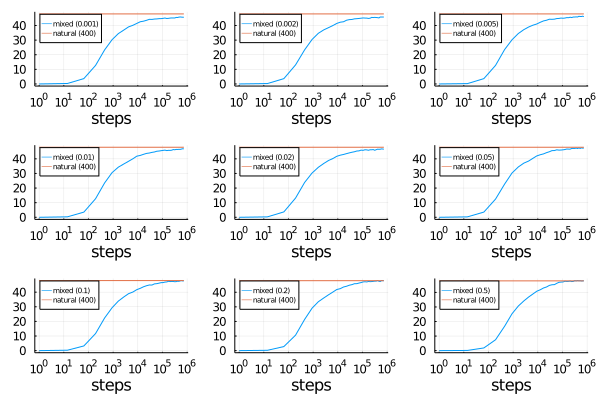

In [170]:
#### Define the layout of the subplots
layout = (3, 3)

# Create an array of 12 plots with the desired data series
plots = [plot(x_steps, dist[i,:], xlabel=:"steps", xscale=:log10, label ="mixed ($(p_sweep[i]))") for i in 1:9]


for i in 1:9
    plot!(plots[i],x_steps, treshold_trim, label="natural ($(nseq[end]))", legend =:topleft)
end

# Group the subplots into a grid and customize the legend
g = plot(plots..., layout=layout, legendfont=font(5), legendlayout=2, plot_size = (1200, 900))

# Display the grid
display(g)

In [117]:
S = length(step_matrices[1][:,1])
nat_MSA, trimmed_nat = reweighting(path_nat, S)
;

θ = 0.2 threshold = 15.0
M = 24944 N = 76 Meff = 3129.1468140631705


In [173]:
step_matrices = load_data("/data/bisardi/my_project/mixed_sweep_seq_correct1:400/files_aminodbd_steps700000_seqs400p0.01/", sampler_type)
;

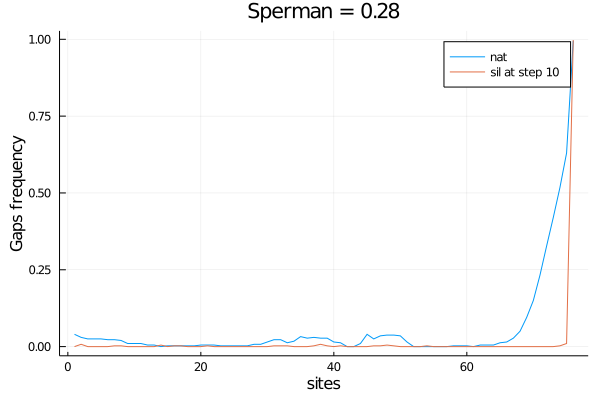

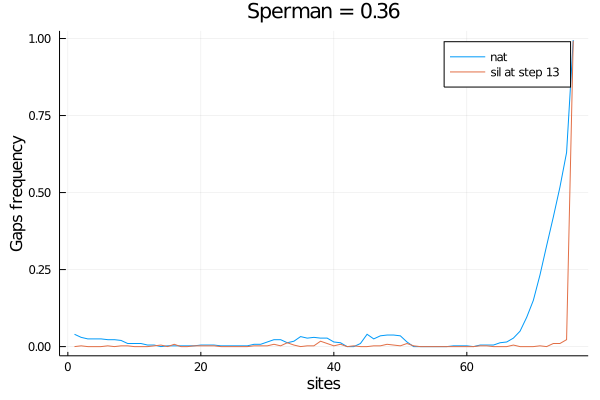

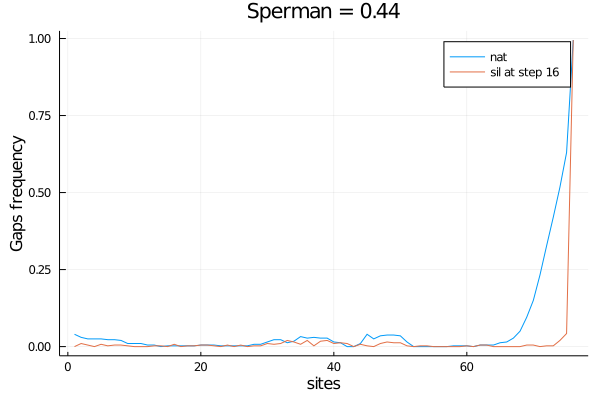

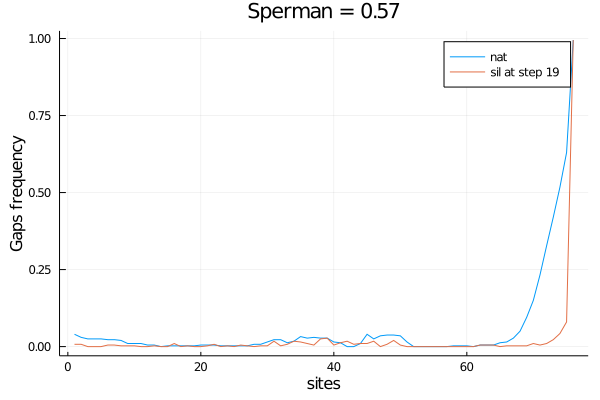

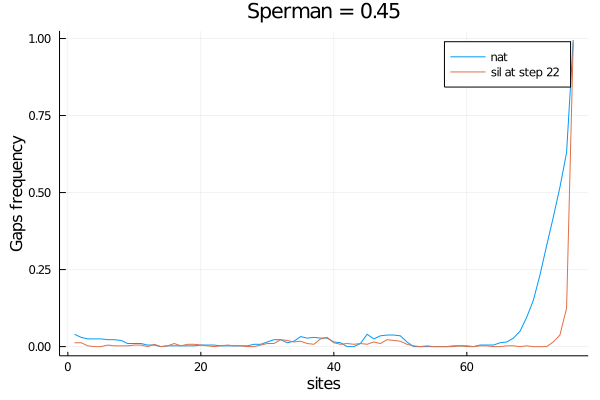

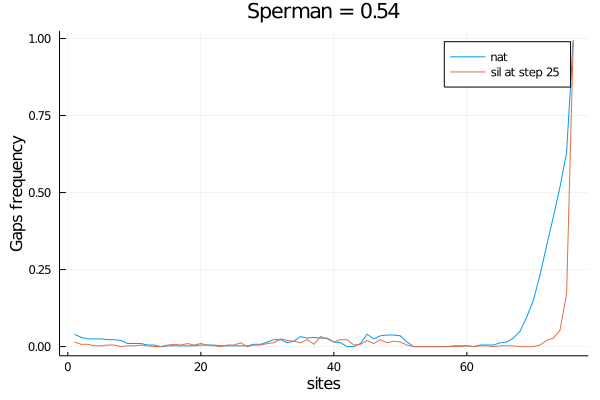

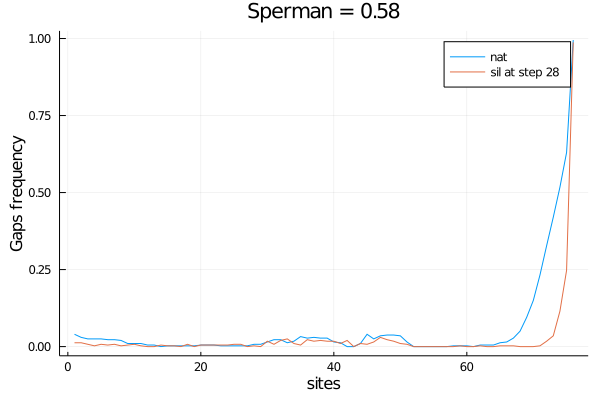

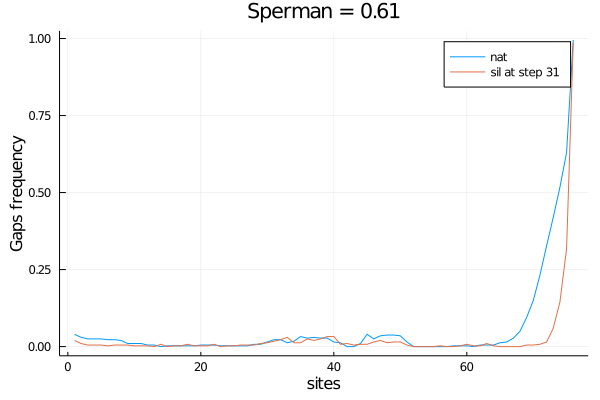

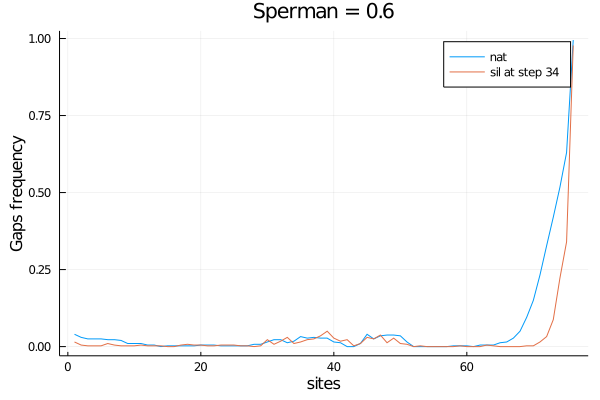

In [174]:
for i in 4:12
    compare_gap_stat(step_matrices, trimmed_nat, val[i]) 
end

In [55]:
@everywhere function nonsaving_parallel_evol_seq_fix_steps_DNA_mixed_nucleo(p, sampler_type::AbstractString, wt_name::AbstractString, ref_seq, 
        MC_steps::Integer, h::Array{Float64,2}, J::Array{Float64,4}, N::Integer, chain_num::Integer, T = 1)
   
            
    #println(ref_seq[chain_num])
    mutated_seq = deepcopy(ref_seq)
    sites = 1:length(mutated_seq.Amino)
    #println("chain $chain_num number of gaps in non_gapped pos: $(sum(21 .== mutated_seq.Amino[non_gapped_pos])),$(sum(21 .== mutated_seq.Amino[non_gapped_pos]))")
    #println("chain $(chain_num), good positions: $(non_gapped_pos)")
    #println("chain $(chain_num), aminos in good positions $(mutated_seq.Amino[non_gapped_pos])")
    #println("chain $(chain_num), codons in good positions $(mutated_seq.DNA[non_gapped_pos])")
    
    #acceptance = 0
    @inbounds for steps in 1: MC_steps
        non_gapped_pos = [pos for (pos, amino) in enumerate(mutated_seq.Amino) if amino != 21]
        if rand()<(1-p)
            mutated_seq = gibbs_step(mutated_seq, non_gapped_pos, h, J, N, T)
        else
            mutated_seq = metro_del_ins_step(mutated_seq, non_gapped_pos, h, J, N, T)
        end     
    end
    return mutated_seq.Amino
    #println("Acceptance ratio (chain $chain_num ) : $(acceptance/MC_steps)")
end
            
            
@everywhere function get_msa(p, sampler_type, wt_name, seed_seq, steps, h, J, N, nseq, T, folder) 
    msa = []
    if sampler_type == "gibbs"
        parallel_evol_seq_fix_steps_DNA_gibbs_nucleo(sampler_type, wt_name, seed_seq, steps, h, J, N, i, T)
        if i%4000 == 0
            println(i)
        end
    elseif sampler_type == "metro"
        for i in 1:nseq
            seq = parallel_evol_seq_fix_steps_DNA_metropolis_nucleo(sampler_type, wt_name, seed_seq, steps, h, J, N, i, T)
            push!(msa, seq)   
        end
    elseif sampler_type == "mixed"
        for i in 1:nseq
            seq = nonsaving_parallel_evol_seq_fix_steps_DNA_mixed_nucleo(p, sampler_type, wt_name, seed_seq, steps, h, J, N, i, T)
            push!(msa, seq)   
        end
    else
        throw(ArgumentError("Invalid sampler type: $sampler_type"))
    end
    output_file = "equil_det_bal_$(wt_name)_steps_$(steps)_T_$(T).$(sampler_type)DNA"
    matrixtofasta(joinpath(folder, output_file), Int8.(hcat(msa...)'))
end
                
                

In [98]:
function find_good_target(results, target_en, target_ham)
        
    scores = []
    for i in 1:length(results[:,1])
        push!(scores, ((results[i,4]-target_en)/target_en)^2 + ((results[i,3]-target_ham)/target_ham)^2)
    end  
        
    value, idx = findmin(scores)
    println(length(scores))
    println("Score is: $value")
    print("Good choice is: ")
    println(results[idx,:])
    
    return Float64.(scores)
end

function load_data(folder_path, sampler_type)
    #println((folder_path, sampler_type))
    fasta_files = filter(file -> endswith(file, ".$(sampler_type)DNA"), readdir(folder_path))
    #println(fasta_files)
    matrices = [Int8.(fasta2matrix(joinpath(folder_path, file))) for file in fasta_files]
    #println((length(matrices[:,1]), length(matrices[1,:])))
    step_matrices = build_seq_matrices(matrices)
    return step_matrices
end

function grid_search(folder, wt_name, wt_ref, rounds, temps, h, J, filename)
    results = []
       
    for steps in rounds
        for T in temps
            
            a = joinpath(folder, "equil_det_bal_$(wt_name)_steps_$(steps)_T_$(T).$(sampler_type)DNA")
            new_MSA = Int8.(fasta2matrix(a))
            
            muts_new = count_muts_msa(new_MSA, wt_ref)
            en_new = KitMSA.energy(h, J, new_MSA)
            mean_muts_new = round.(mean(muts_new); digits=2)
            mean_en_new = round.(mean(en_new); digits=2)
            
            info = [steps, T, mean_muts_new, mean_en_new]
            push!(results, info)
            
        end
    end
    
    writedlm(filename, results)
end

grid_search (generic function with 1 method)

In [66]:
p=0.5

sampler_type = "mixed"
nseq = 1000

#wt_name = "tem"
wt_name = "pse"
N = length(nat_MSA[1,:])

seed_seq = seed_seq_pse
#seed_seq = seed_seq_tem

folder = "../src/trialpse2/"
mkdir(folder)


"../src/trialpse2/"

In [56]:
@everywhere function parallel_get_msa(input)
    get_msa(p, sampler_type, wt_name, seed_seq, input[2], h, J, N, nseq, input[1], folder)
    #println(input)
end    

In [46]:
for ww in workers()
    fetch(@spawnat ww p, sampler_type, wt_name, seed_seq, h, J, N, nseq, folder)
    #println("fetched")
end

In [67]:
for ww in workers()
    fetch(@spawnat ww p, wt_name, seed_seq, nseq, folder)
    #println("fetched")
end

In [68]:
temps= range(1.3, step=0.01, 1.4)
rounds = range(240, step=2, 270)
inputs = []
for t in temps
    for r in rounds
        push!(inputs, (t, r))
    end
end
inputs
start=time()
pmap(parallel_get_msa, inputs)
fine=time()
println(fine-start)
println("MSAs GENERATED!!")

38.337916135787964
MSAs GENERATED!!


In [69]:
filename = "../src/parpsemixed2.txt"
@time grid_search(folder, wt_name, pse_amino_seq, rounds, temps, h, J, filename)
#@time grid_search(folder, wt_name, tem_amino_seq, rounds, temps, h, J, filename)
results = readdlm(filename)
#find_good_target(results, -4.12, 17.89) #tem
find_good_target(results, 16.73, 24.62) #pse


 32.379910 seconds (1.63 M allocations: 330.087 MiB, 0.59% gc time)
176
Score is: 7.811066756778708e-5
Good choice is: [256.0, 1.33, 24.69, 16.59]


176-element Array{Float64,1}:
 0.027359599704109488
 0.01743300627350863
 0.011001119550748659
 0.006204682826900601
 0.0021098092579982138
 0.0017918185256088934
 0.001767380213090528
 0.006756664470574212
 0.004846042664113791
 0.008047812726764886
 0.02320913323173312
 0.015935134632639233
 0.015582083445496362
 ⋮
 0.0768955116261453
 0.009484232930199671
 0.0027452420844930507
 0.0019300104193837918
 0.004429905611550038
 0.0026448575945639424
 0.01242024317895319
 0.02612692740670082
 0.02389285858966404
 0.04452902787035303
 0.07645118765381054
 0.06862990871465227

In [17]:
function pairwise_hamming(msa::Array{Int8,2})
    num_seqs = size(msa, 1)
    pairwise_distances = Array{Int,1}(undef, num_seqs*(num_seqs-1)÷2)
    idx = 1
    for i in 1:num_seqs-1
        for j in i+1:num_seqs
            dist = KitMSA.my_hamming(msa[i,:], msa[j,:])
            pairwise_distances[idx] = dist
            idx += 1
        end
    end
    return pairwise_distances
end

function project_pca(filename, label1, label2, eigenv, pc_ref, one_non_ref)
    pc_proj = eigenv[:, [end, end-1]]'*one_non_ref'
    scatter(pc_nat[1,:], pc_nat[2,:], alpha = 0.25, xlabel ="pc1", ylabel="pc2", label= label1, legend=:topleft, xguidefontsize =16,yguidefontsize =16,
        legendfontsize=16)
    scatter!(pc_proj[1,:], pc_proj[2,:], alpha = 0.25,color=:red, label= label2 )
    ylims!(-5., 5.)
    xlims!(-10., 4.)
    savefig(filename)
end

function plot_pca(pc_ref, eigenv, matrices, filepath)
    
    for i in 1:length(matrices)
        one_hot_proj = one_hot(matrices[i])
        project_pca(joinpath(filepath, "pca$(i).png"), "nat", "sil step $(i)", eigenv, pc_ref, one_hot_proj)
        println(i)
    end
end

function sweep2(ref_MSA, MSAs, n_points, steps, file)
    
    first_ref, second_ref = compute_weighted_frequencies(Int8.(ref_MSA'), 0.2)
    
    first = []
    second = []
    
    for matrix in red_MSAs
        a, b = compute_weighted_frequencies(Int8.(matrix'),0)
        push!(first, a)
        push!(second, b)
    end
        
    r_spearman1 = [corspearman(first_ref, f) for f in first]
    r_pearson1 = [cor(first_ref, f) for f in first]
    
    r_spearman2 = [corspearman(second_ref, f) for f in second]
    r_pearson2 = [cor(second_ref, f) for f in second]
    
    scatter(red_steps, r_spearman1, xscale=:log10, label ="spearman first", legend=:bottomright)
    scatter!(red_steps, r_pearson1, label ="pearson first")
    scatter!(red_steps, r_spearman2, label ="spearman second")
    scatter!(red_steps, r_pearson2, label ="pearson second")
    
    savefig(file)
    
end

function adjust_two_point(matrix, freqs)
    N = Int.(length(freqs)/20)
    q = 20
    for i in 1:N
        for j in 1:N
            for a in 1:20
                for b in 1:20
                    if i != j 
                        matrix[a+(i-1)*q , b+(j-1)*q]-=freqs[a+(i-1)*q]*freqs[b+(j-1)*q]
                    end
                end
            end
        end
    end
end


function give_simul_results(folder_path, path_nat, sampler_type, output_folder, h, J)
    
    fasta_files = filter(file -> endswith(file, ".$(sampler_type)DNA"), readdir(folder_path))
    matrices = [Int8.(fasta2matrix(joinpath(folder_path, file))) for file in fasta_files]
    step_matrices = build_seq_matrices(matrices)
    S = length(step_matrices[1][:,1])
    N = length(step_matrices[1][1,:])
    println((N,S))
    steps = round.(Int, [n^(3.8) for n in 1:length(step_matrices)])
    #steps = round.(Int, [(1.3)^n for n in 1:length(step_matrices)])
    nat_MSA = Int8.(fasta2matrix(path_nat))
    W_nat = DCAUtils.compute_weights(Int8.(nat_MSA'),0.2)[1]
    idxs = sample(1:length(W_nat), Weights(W_nat), S, replace=true)
    trimmed_nat = nat_MSA[idxs,:]
    
    mean_dist_steps = [mean(pairwise_hamming(matrix)) for matrix in step_matrices]
    std_dist_steps = [std(pairwise_hamming(matrix)) for matrix in step_matrices]
    mu_trim = mean(pairwise_hamming(trimmed_nat))
    dev_std_trim = std(pairwise_hamming(trimmed_nat))
    treshold_trim = [mu_trim for n in 1:length(mean_dist_steps)]
    d = pairwise_hamming(step_matrices[end])
    #d_nat = pairwise_hamming(filter_alignment(S, nat_MSA))
    d_trim = pairwise_hamming(trimmed_nat)
    n_bins = 20
    histogram(d_trim, bins = n_bins, alpha = 0.5, xlabel="pairwise distance", xguidefontsize =16, 
        label = "nat", normalize=:pdf, legend=:topleft, legendfontsize=16)
    histogram!(d, bins = n_bins, alpha = 0.5, normalize=:pdf, label = "sil")
    #histogram!(d_nat, bins=30, alpha = 0.5, label = "nat total")
    savefig(joinpath(output_folder, "pairwise_dist_distrib.png"))
    
    scatter(steps, mean_dist_steps, yerr = std_dist_steps, xlabel=:"steps", ylabel=:"mean pairwise distance", 
        xguidefontsize =16, yguidefontsize =16, legendfontsize=12,
        xscale=:log10, label ="simulated", legend=:bottomright)
    plot!(steps, treshold_trim, ribbon = dev_std_trim, label="natural ($(S) seq)")
    ylims!(-5., N)
    savefig(joinpath(output_folder, "pairwise_dist_evolution.png"))
    
    en = KitMSA.energy(h,J,step_matrices[end])
    #en_nat = KitMSA.energy(h,J,nat_MSA)
    en_nat_trim = [KitMSA.energy(h, J, trimmed_nat[i,:]) for i in 1:length(trimmed_nat[:, 1])]
    #histogram(en_nat, bins=30, alpha = 0.5, xlabel=:"Energy", label = "nat")
    histogram(en, bins = 15, alpha = 0.5, normalize=:pdf, xlabel="energy", label = "sil", 
        xguidefontsize =16, yguidefontsize =16, legendfontsize=16)
    histogram!(en_nat_trim, bins = 15, alpha = 0.5,normalize=:pdf, xlabel="energy", label = "nat")
    savefig(joinpath(output_folder, "energy.png"))

    first = []
    second = []
    
    first_ref, second_ref = compute_weighted_frequencies(Int8.(nat_MSA'), 0.2)
    adjust_two_point(second_ref, first_ref)
    
    val = 1:3:length(step_matrices)
    s = steps[val]
    println(length(step_matrices[val]))
    for matrix in step_matrices[val]
        a, b = compute_weighted_frequencies(Int8.(matrix'),0)
        adjust_two_point(b,a)
        push!(first, a)
        push!(second, b)        
    end
        
    r_spearman1 = [corspearman(first_ref, f) for f in first]
    r_pearson1 = [cor(first_ref, f) for f in first]
    scatter(s, r_spearman1, xscale=:log10, xlabel=:"steps", ylabel=:"Frequencies correlation", 
        label ="spearman", xguidefontsize =16, yguidefontsize =16,
        legendfontsize=16, legend=:bottomright)
    scatter!(s, r_pearson1, label ="pearson")
    ylims!(0, 1.2)
    savefig(joinpath(output_folder, "first_stat.png"))
    
    
    gaps_freq_nat = [sum(trimmed_nat[:,i] .== 21) for i in 1:N] ./ length(trimmed_nat[:,1])
    gaps_freq = [sum(step_matrices[end][:,i] .== 21) for i in 1:N] ./ length(step_matrices[end][:,1])
    r_gap =round.(corspearman(gaps_freq, gaps_freq_nat), digits = 2)
    plot(gaps_freq_nat, xlabel="sites", ylabel="Gaps frequency", xguidefontsize =16,yguidefontsize =16,
        legendfontsize=16, label ="nat")
    plot!(gaps_freq, xlabel="sites", label ="sil (spearman = $r_gap)")
    savefig(joinpath(output_folder, "gap_first_stat.png"))
    
    r_2 = []
    for f in second
        x = cor(vec(second_ref) .+ 10^(-5), vec(f) .+ 10^(-5))
        push!(r_2, x)
        #println(x)
    end
    #println(r_spearman2)
    scatter(s, r_2, xscale=:log10, xlabel=:"steps", label ="pearson", xguidefontsize =16,yguidefontsize =16,
        legendfontsize=16,legend=:topleft)
    ylims!(0, 1.)
    savefig(joinpath(output_folder, "second_stat.png"))   
    
    
    one_hot_nat = one_hot(nat_MSA)
    W_nat=DCAUtils.compute_weights(Int8.(nat_MSA'),0.2)[1]
    # compute covariance of data
    cov_nat = cov(one_hot_nat, pweights(W_nat))

    # compute eigenvalues and eigenvectors of covariance matrix
    eigenvecs_nat = eigvecs(cov_nat)
    eigenvals_nat = eigvals(cov_nat)

    # project natural data onto principal components
    pc_nat = eigenvecs_nat[:, [end, end-1]]'*one_hot_nat'
    #val = 1:10:length(step_matrices)
    
    out=joinpath(output_folder,"pca/")
    plot_pca(pc_nat, eigenvecs_nat, step_matrices, out)

end


give_simul_results (generic function with 1 method)

In [18]:
function compare_gap_stat(step_matrices, trimmed_nat, idx)
    gaps_freq_nat = [sum(trimmed_nat[:,i] .== 21) for i in 1:N] ./ length(trimmed_nat[:,1])
    gaps_freq = [sum(step_matrices[idx][:,i] .== 21) for i in 1:N] ./ length(step_matrices[idx][:,1])
    r_gap =round.(corspearman(gaps_freq, gaps_freq_nat), digits = 2)
    p = plot(gaps_freq_nat, xlabel="sites", ylabel="Gaps frequency", label ="nat", title ="Sperman = $r_gap")
    plot!(p, gaps_freq, xlabel="sites", label ="sil at step $(idx)")
    display(p)
end   

compare_gap_stat (generic function with 1 method)

In [169]:
#folder_path = "/data/bisardi/my_project/chains_aminoandcodon/files_amino_metro_pse_steps60000000_seqs1000_T1.0/"
folder_path = "/data/bisardi/my_project/mixed_chains/files_amino_mixed_pse_steps60000000_seqs1000_T1.0p0.5"   ## good choice

sampler_type = "mixed"
path_nat = "../alignments/natural/PF13354_noinsert_max19gaps_nodupl_noclose.faa"
@time give_simul_results(folder_path, path_nat, sampler_type, output_folder, h, J)

(202, 1000)
θ = 0.2 threshold = 40.0
M = 18334 N = 202 Meff = 6875.804074759526
θ = 0.2 threshold = 40.0
M = 18334 N = 202 Meff = 6875.804074759526
38
θ = 0.0 threshold = 0.0
M = 1000 N = 202 Meff = 1000
θ = 0.0 threshold = 0.0
M = 1000 N = 202 Meff = 1000
θ = 0.0 threshold = 0.0
M = 1000 N = 202 Meff = 1000
θ = 0.0 threshold = 0.0
M = 1000 N = 202 Meff = 1000
θ = 0.0 threshold = 0.0
M = 1000 N = 202 Meff = 1000
θ = 0.0 threshold = 0.0
M = 1000 N = 202 Meff = 1000
θ = 0.0 threshold = 0.0
M = 1000 N = 202 Meff = 1000
θ = 0.0 threshold = 0.0
M = 1000 N = 202 Meff = 1000
θ = 0.0 threshold = 0.0
M = 1000 N = 202 Meff = 1000
θ = 0.0 threshold = 0.0
M = 1000 N = 202 Meff = 1000
θ = 0.0 threshold = 0.0
M = 1000 N = 202 Meff = 1000
θ = 0.0 threshold = 0.0
M = 1000 N = 202 Meff = 1000
θ = 0.0 threshold = 0.0
M = 1000 N = 202 Meff = 1000
θ = 0.0 threshold = 0.0
M = 1000 N = 202 Meff = 1000
θ = 0.0 threshold = 0.0
M = 1000 N = 202 Meff = 1000
θ = 0.0 threshold = 0.0
M = 1000 N = 202 Meff = 1000
θ

In [19]:
one_hot_nat = one_hot(nat_MSA)
W_nat=DCAUtils.compute_weights(Int8.(nat_MSA'),0.2)[1]
# compute covariance of data
cov_nat = cov(one_hot_nat, pweights(W_nat))

# compute eigenvalues and eigenvectors of covariance matrix
eigenvecs_nat = eigvecs(cov_nat)
eigenvals_nat = eigvals(cov_nat)
;

θ = 0.2 threshold = 40.0
M = 18334 N = 202 Meff = 6875.804074759526


In [99]:
step_matrices=load_data(folder_path, sampler_type)
;

In [22]:


function project_pca_traj(filename, label1, label2, eigenv, pc_ref, one_non_ref)
    pc_proj = eigenv[:, [end, end-1]]'*one_non_ref'
    scatter(pc_nat[1,:], pc_nat[2,:], alpha = 0.25, label= label1, legend=:topleft, xguidefontsize =16,yguidefontsize =16,
        legendfontsize=16)
    plot!(pc_proj[1,:], pc_proj[2,:], alpha = 0.25,color=:red, label= label2 )
    savefig(filename)
end



function plot_pca_trajectory(pc_ref, eigenv, matrices, filepath)
    for i in 1;
    one_hot_proj = one_hot(matrices)
    project_pca_traj(joinpath(filepath, "pca.png"), "nat", "sil TRAJ", eigenv, pc_ref, one_hot_proj)
end

LoadError: syntax: incomplete: "function" at In[22]:13 requires end

In [20]:
folder_path = "/data/bisardi/my_project/mixed_chains/files_amino_mixed_pse_steps60000000_seqs1000_T1.0p0.5"
fasta_files = filter(file -> endswith(file, ".mixedDNA"), readdir(folder_path))
@time matrices = [Int8.(fasta2matrix(joinpath(folder_path, file))) for file in fasta_files]
;

  3.821722 seconds (913.77 k allocations: 185.024 MiB)


In [23]:
pc_nat = eigenvecs_nat[:, [end, end-1]]'*one_hot_nat'
#val = 1:10:length(step_matrices)
output_folder = "../my_project/images/long-term/aminoandcodons_off/mixed/betalac/"

#plot_pca_trajectory(pc_nat, eigenvecs_nat, matrices[1], output_folder)

"../my_project/images/long-term/aminoandcodons_off/mixed/betalac/"

In [27]:
scatter(pc_nat[1,:], pc_nat[2,:], alpha = 0.25, color=:black, label= "nat", legend=:topleft)
for i in 1:1
    one_hot_proj = one_hot(matrices[i+2])
    pc_proj = eigenvecs_nat[:, [end, end-1]]'*one_hot_proj'
    plot!(pc_proj[1,:], pc_proj[2,:], xlabel ="pc1", ylabel="pc2", marker = :circle, alpha=1.25, xguidefontsize =16,yguidefontsize =16,
        legendfontsize=16, label= "")
end
savefig("../my_project/images/long-term/aminoandcodons_off/mixed/betalac/pca_traj3.png")